In [7]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pymatgen.symmetry.groups import SpaceGroup
from tqdm import tqdm  # For progress bar

In [ ]:
# Load parquet files and extract relevant features
def load_and_extract_features(file_list):
    """
    Load parquet files and extract relevant features.

    Parameters:
    - file_list (list): List of file paths to parquet files.

    Returns:
    - combined_df (DataFrame): Combined DataFrame with relevant features.
    """
    combined_data = []

    for file in tqdm(file_list, desc='Processing files'):
        # Read only necessary columns
        columns_to_read = [
            'descriptors.soap_gen',
            'descriptors.acsf_gen',
            'descriptors.xrd_gen.iq',
            'dataset_name',
            'spacegroup',
            'seq_len'
        ]
        df = pd.read_parquet(file, columns=columns_to_read)

        # Convert feature columns to numpy arrays
        for col in ['descriptors.soap_gen', 'descriptors.acsf_gen', 'descriptors.xrd_gen.iq']:
            df[col] = df[col].apply(np.array)

        combined_data.append(df)

    combined_df = pd.concat(combined_data, ignore_index=True)

    # Convert 'spacegroup' to integer numbers
    def get_spacegroup_int(sg):
        try:
            return SpaceGroup(sg).int_number
        except:
            return np.nan

    combined_df['spacegroup_int'] = combined_df['spacegroup'].apply(get_spacegroup_int)

    return combined_df

# Assuming files are in the specified directory with the ".eval" extension
file_list = [
    "../deciferdataset_no_boundary/no_boundary_test5k.eval",
    "../deciferdataset_boundary/boundary_test5k.eval",
]#glob.glob("../uncon_trained_models/crystal500k_25M_2048/test.eval")

# Load and extract relevant features
df = load_and_extract_features(file_list)


Processing files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.35it/s]


In [2]:
import torch
import os
import sys
sys.path.append("./")
import yaml
import numpy as np
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from time import time

from decifer import (
    Tokenizer,
    Decifer,
    DeciferConfig,
    HDF5Dataset,
    DeciferDataset,
    extract_prompt,
    extract_prompt_batch,
    load_model_from_checkpoint,
    reinstate_symmetry_loop,
    extract_space_group_symbol,
    replace_symmetry_loop_with_P1,
    bond_length_reasonableness_score,
    is_space_group_consistent,
    is_formula_consistent,
    is_atom_site_multiplicity_consistent,
    is_sensible,
    is_valid,
    print_hdf5_structure,
    evaluate_syntax_validity,
    extract_numeric_property,
    get_unit_cell_volume,
    extract_volume,
)

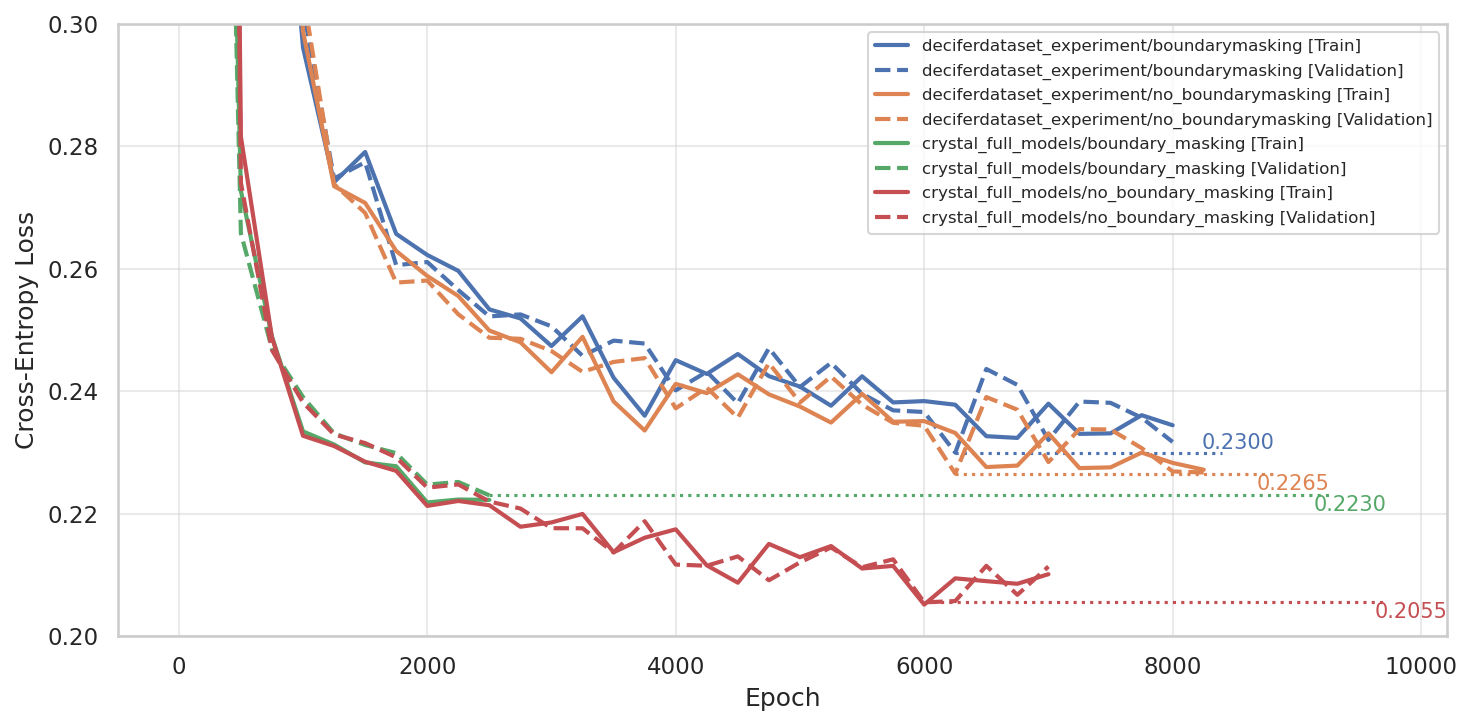

In [2]:
from decifer import (
    plot_loss_curves,
)

plot_loss_curves(
    [
        "../cross-contamination/deciferdataset_experiment/boundarymasking/ckpt.pt",
        "../cross-contamination/deciferdataset_experiment/no_boundarymasking/ckpt.pt",
        "../cross-contamination/crystal_full_models/boundary_masking/ckpt.pt",
        "../cross-contamination/crystal_full_models/no_boundary_masking/ckpt.pt",
    ],
    ylog = False,
    ymin = 0.2,
    ymax = 0.3,
    figsize=(10,5),
)

<Figure size 750x750 with 0 Axes>

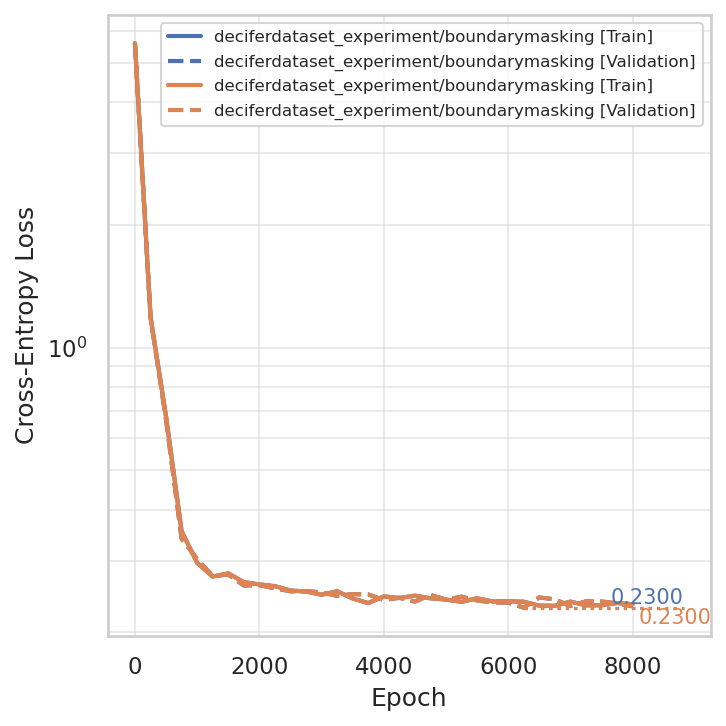

In [5]:
from decifer import (
    plot_loss_curves,
)

plot_loss_curves(
    [
        "../cross-contamination/deciferdataset_experiment/boundarymasking/ckpt.pt",
        "../cross-contamination/deciferdataset_experiment/boundarymasking/ckpt.pt",
    ],
    ylog = True,
    figsize=(5,5)
)

In [5]:
# Config path
config_path = "../configs/testconfig.yaml"

# Get config
with open(config_path, "r") as f:
    yaml_config = yaml.safe_load(f)
config = OmegaConf.create(yaml_config)

# Make dataset from test
h5_test_path = os.path.join("../data/crystallm/5k/hdf5/train_dataset.h5")
test_dataset = HDF5Dataset(
    h5_test_path,
    ["cif_tokenized"], 
    block_size=10000,
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_path = os.path.join('../test/ckpt.pt')  # Update with your actual checkpoint path

if os.path.exists(ckpt_path):
    model = load_model_from_checkpoint(ckpt_path, device)
else:
    print(f"Checkpoint file not found at {ckpt_path}")
    
model.eval();  # Set the model to evaluation mode
model.device = 'cuda'

# ckpt_path = os.path.join('../test_noboundarymasking/ckpt.pt')  # Update with your actual checkpoint path

# if os.path.exists(ckpt_path):
#     model_noboundary = load_model_from_checkpoint(ckpt_path, device)
# else:
#     print(f"Checkpoint file not found at {ckpt_path}")
    
# model_noboundary.eval();  # Set the model to evaluation mode
# model_noboundary.device = 'cuda'

# decode = Tokenizer().decode

for i, sample in enumerate(iter(test_dataset)):
    print(sample[0])
    prompt = extract_prompt(sample[0], model.device, add_composition=True, add_spacegroup=False).unsqueeze(0)
    print(prompt)
    if prompt is not None:
        print()
        print("Efficient packing w/ proper boundary handling:\n")
        out = model.generate(prompt, max_new_tokens=1000, disable_pbar=True)[0].cpu().numpy()
        cif = decode(out)
        cif = replace_symmetry_loop_with_P1(cif)
        spacegroup_symbol = extract_space_group_symbol(cif)
        if spacegroup_symbol != "P 1":
            cif = reinstate_symmetry_loop(cif, spacegroup_symbol)
        print(cif)
        print("Efficient packing w/o proper boundary handling:\n")
        out = model_noboundary.generate(prompt, max_new_tokens=1000, disable_pbar=True)[0].cpu().numpy()
        cif = decode(out)
        cif = replace_symmetry_loop_with_P1(cif)
        spacegroup_symbol = extract_space_group_symbol(cif)
        if spacegroup_symbol != "P 1":
            cif = reinstate_symmetry_loop(cif, spacegroup_symbol)
        print(cif)
        break

Processing datasets:   0%|          | 0/1 [00:00<?, ?it/s]

number of total parameters: 0.57M
tensor([124,  25,  90,  ..., 371, 371, 371])
tensor([[124,  25,  90,  14,  91,   7,  92, 142]], device='cuda:0')

Efficient packing w/ proper boundary handling:



NameError: name 'decode' is not defined

In [33]:
# Config path
config_path = "../configs/testconfig.yaml"

# Get config
with open(config_path, "r") as f:
    yaml_config = yaml.safe_load(f)
config = OmegaConf.create(yaml_config)

# Make dataset from test
h5_test_path = os.path.join("../data/crystallm/5k/hdf5/train_dataset.h5")
test_dataset = HDF5Dataset(
    h5_test_path,
    ["cif_tokenized"], 
    block_size=10000,
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_path = os.path.join('../test/ckpt.pt')  # Update with your actual checkpoint path

if os.path.exists(ckpt_path):
    model = load_model_from_checkpoint(ckpt_path, device)
else:
    print(f"Checkpoint file not found at {ckpt_path}")
    
model.eval();  # Set the model to evaluation mode
model.device = 'cuda'

ckpt_path = os.path.join('../test_noboundarymasking/ckpt.pt')  # Update with your actual checkpoint path

if os.path.exists(ckpt_path):
    model_noboundary = load_model_from_checkpoint(ckpt_path, device)
else:
    print(f"Checkpoint file not found at {ckpt_path}")
    
model_noboundary.eval();  # Set the model to evaluation mode
model_noboundary.device = 'cuda'

decode = Tokenizer().decode

for i, sample in enumerate(iter(test_dataset)):
    prompt = extract_prompt(sample[0], model.device, add_composition=True, add_spacegroup=True).unsqueeze(0)
    if prompt is not None:
        print()
        print("Efficient packing w/ proper boundary handling:\n")
        out = model.generate_and_print(prompt, max_new_tokens=1000)[0].cpu().numpy()
        print("Efficient packing w/o proper boundary handling:\n")
        out = model_noboundary.generate_and_print(prompt, max_new_tokens=1000)[0].cpu().numpy()
        break

Processing datasets:   0%|          | 0/1 [00:00<?, ?it/s]

number of total parameters: 25.36M
number of total parameters: 25.36M

Efficient packing w/ proper boundary handling:

data_Mg1Mn2O3
loop_
_atom_type_symbol
_atom_type_electronegativity
_atom_type_radius
_atom_type_ionic_radius
Mg 1.3100 1.5000 0.8600
Mn 1.5500 1.4000 0.6483
O 3.4400 0.6000 1.2600
_symmetry_space_group_name_H-M P-3m1
_cell_length_b 11.0.4307
_cell_length_c 5.4400
_cell_length_c 16.3794
_cell_angle_alpha 90.00
_cell_angle_beta 90.0000 123.0000
_cell_angle_beta 9 9 0.0000 1.0000
_cell_angle_gamma 9 00 1.0000
_symmetry_Int_Tables_number 1200
_chemical_formula_structural Sr2 6 0.0000 0.2322 1.0000
_chemical_formula_structural Ac2 6 0.0000 0.3577 0.0000 1.0000
Ti Ti3 6 0.0000 0.3646 0.7500 1.0000
O O4 12 0.2388 0.4961 0.1688 1.0000
O O5 6 0.0200 0.3437 0.3500 1.0000
O O6 6 0.0399 0.6301 0.8868 1.0000
O O7 6 0.0335 0.1463 0.4160 1.0000
O O8 6 0.0557 0.3551 0.8376 1.0000
O O9 6 0.1981 0.6805 0.5233 1.0000
O O10 6 0.2073 0.4673 0.7956 1.0000
O O11 6 0.2500 0.5711 0.5000 1.0000

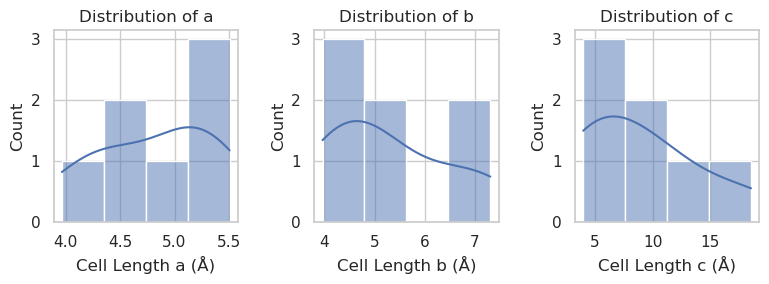

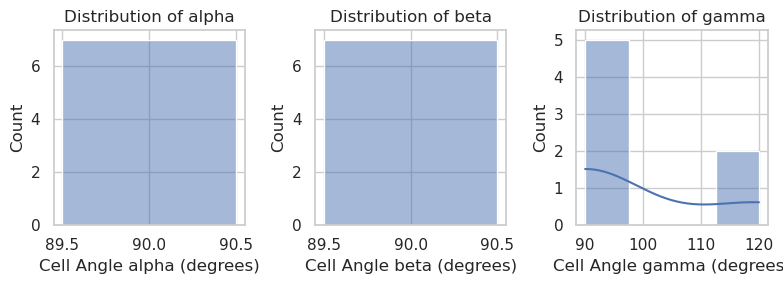

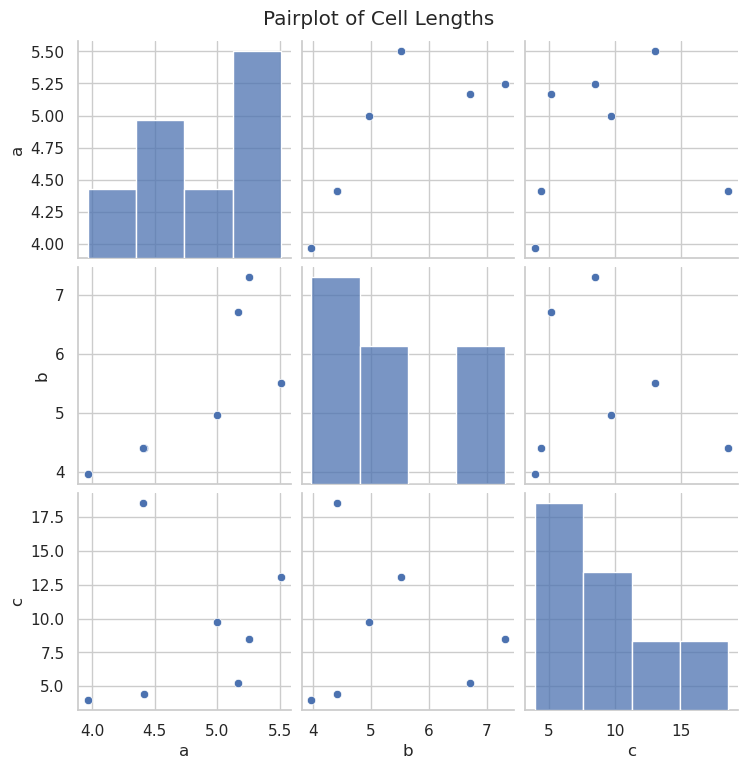

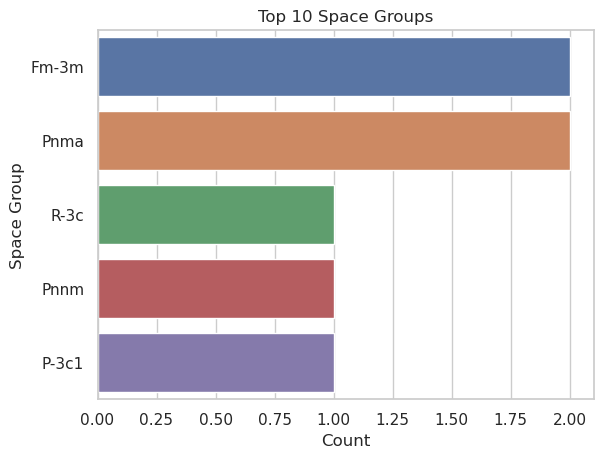

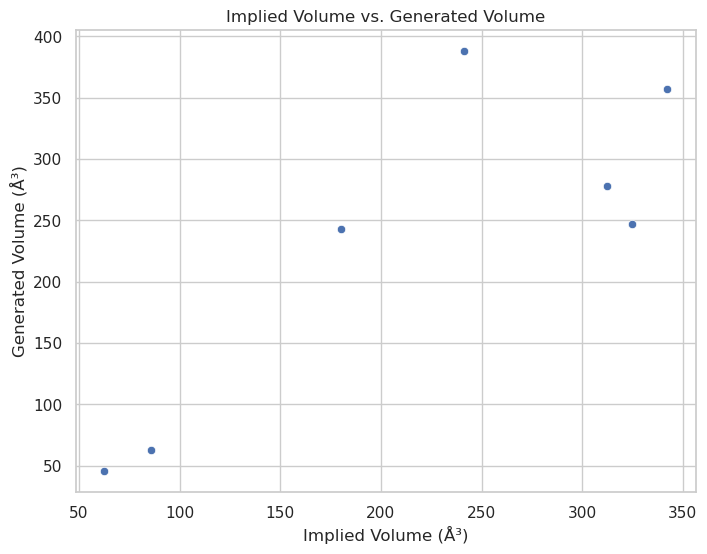

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style='whitegrid')

# Path to your Parquet file (update if you used a custom extension)
parquet_file_path = '../train.eval'  # or your custom extension

# Read the Parquet file into a DataFrame
df = pd.read_parquet(parquet_file_path)

# Rename cell parameter columns if necessary
cell_param_cols = [col for col in df.columns if col.startswith('cell_params.')]

if cell_param_cols:
    # Rename columns to remove 'cell_params.' prefix
    df.rename(columns=lambda x: x.replace('cell_params.', '') if x.startswith('cell_params.') else x, inplace=True)
else:
    print("No 'cell_params' columns found.")

# Now, 'a', 'b', 'c', etc., are direct columns in df
numeric_cols = ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'implied_vol', 'gen_vol']

# Convert numeric columns to appropriate data types
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# **Create an overall 'syntax_validity' column**
syntax_validity_checks = [
    'syntax_validity.formula_consistency',
    'syntax_validity.atom_site_multiplicity',
    'syntax_validity.space_group_consistency'
]

# Ensure these columns exist
missing_checks = [check for check in syntax_validity_checks if check not in df.columns]
if missing_checks:
    print(f"Missing syntax validity checks: {missing_checks}")
    # Optionally, you can fill missing columns with False
    for check in missing_checks:
        df[check] = False  # or handle as appropriate

# Ensure that these columns are boolean
df[syntax_validity_checks] = df[syntax_validity_checks].astype(bool)

# **Combine individual checks into an overall syntax validity**
df['syntax_validity'] = df[syntax_validity_checks].all(axis=1)

# For example, plot histograms for cell lengths (a, b, c)
plt.figure(figsize=(8, 3))
for i, param in enumerate(['a', 'b', 'c']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[param].dropna(), kde=True)
    plt.title(f'Distribution of {param}')
    plt.xlabel(f'Cell Length {param} (Å)')
plt.tight_layout()
plt.show()

# Plot histograms for cell angles (alpha, beta, gamma)
plt.figure(figsize=(8, 3))
for i, param in enumerate(['alpha', 'beta', 'gamma']):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[param].dropna(), kde=True)
    plt.title(f'Distribution of {param}')
    plt.xlabel(f'Cell Angle {param} (degrees)')
plt.tight_layout()
plt.show()

# Pairplot of cell lengths to examine relationships
sns.pairplot(df[['a', 'b', 'c']].dropna())
plt.suptitle('Pairplot of Cell Lengths', y=1.02)
plt.show()

# Bar plot of the top 10 most common space groups
top_spacegroups = df['spacegroup'].value_counts().head(10)
sns.barplot(y=top_spacegroups.index, x=top_spacegroups.values, orient='h')
plt.title('Top 10 Space Groups')
plt.xlabel('Count')
plt.ylabel('Space Group')
plt.show()

# Scatter plot of implied volume vs. generated volume
plt.figure(figsize=(8, 6))
sns.scatterplot(x='implied_vol', y='gen_vol', data=df)
plt.title('Implied Volume vs. Generated Volume')
plt.xlabel('Implied Volume (Å³)')
plt.ylabel('Generated Volume (Å³)')
plt.show()

In [6]:
import pandas as pd
import numpy as np

# Path to your evaluation data file
evaluation_file_path = '../train.eval'  # Update if you have a custom extension

# Read the evaluation data into a DataFrame
df = pd.read_parquet(evaluation_file_path)

# Ensure required columns exist
required_columns = [
    'Dataset',
    'Model',
    'cif',
    'syntax_validity.space_group_consistency',
    'syntax_validity.atom_site_multiplicity'
]

missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the DataFrame: {missing_columns}")

# Ensure validity columns are boolean
df['syntax_validity.space_group_consistency'] = df['syntax_validity.space_group_consistency'].astype(bool)
df['syntax_validity.atom_site_multiplicity'] = df['syntax_validity.atom_site_multiplicity'].astype(bool)

# Calculate overall validity (since BLRS is ignored)
df['valid'] = df[['syntax_validity.space_group_consistency', 'syntax_validity.atom_site_multiplicity']].all(axis=1)

# Group by Dataset and Model to compute statistics
grouped = df.groupby(['Dataset', 'Model'])

# Initialize a list to store the results
results = []

# Loop over each group to calculate statistics
for (dataset, model), group in grouped:
    total_samples = len(group)
    
    # SG [%]
    sg_pass = group['syntax_validity.space_group_consistency'].sum()
    sg_percentage = (sg_pass / total_samples) * 100
    
    # ASM [%]
    asm_pass = group['syntax_validity.atom_site_multiplicity'].sum()
    asm_percentage = (asm_pass / total_samples) * 100
    
    # Valid [%]
    valid_pass = group['valid'].sum()
    valid_percentage = (valid_pass / total_samples) * 100
    
    # Average valid sequence length
    valid_seq_lengths = group.loc[group['valid'], 'seq_len']
    if not valid_seq_lengths.empty:
        avg_seq_length = valid_seq_lengths.mean()
        std_seq_length = valid_seq_lengths.std()
        seq_length_str = f"{avg_seq_length:.1f} ± {std_seq_length:.1f}"
    else:
        seq_length_str = "N/A"
    
    # Store the results
    results.append({
        'Dataset': dataset,
        'Model': model,
        'SG [%]': f"{sg_percentage:.1f}",
        'ASM [%]': f"{asm_percentage:.1f}",
        'Valid [%]': f"{valid_percentage:.1f}",
        'Avg. Valid Seq. Len.': seq_length_str
    })

# Convert results to a DataFrame for easier display
results_df = pd.DataFrame(results)

# Display the results
print("Generated Table Values:")
print()
print(results_df.to_string(index=False))


Generated Table Values:

Dataset    Model SG [%] ASM [%] Valid [%] Avg. Valid Seq. Len.
  train ucon-25M   14.3    28.6       0.0                  N/A


In [33]:
# Generate LaTeX table rows
latex_rows = []
current_dataset = None

for index, row in results_df.iterrows():
    dataset = row['Dataset']
    model = row['Model']
    sg = row['SG [%]']
    asm = row['ASM [%]']
    valid = row['Valid [%]']
    avg_seq_len = row['Avg. Valid Seq. Len.']
    
    # Start a new dataset block if necessary
    if dataset != current_dataset:
        latex_rows.append(r"& \multirow{{c}}{{*}}{{{}}} ".format(dataset))
        current_dataset = dataset
    else:
        latex_rows.append("& ")
    
    # Add model and statistics
    latex_row = "& {} & {} & {} & {} & {} \\\\".format(
        model, sg, asm, valid, avg_seq_len
    )
    latex_rows.append(latex_row)
    
    # Add midrule between datasets
    if index < len(results_df) - 1:
        next_dataset = results_df.iloc[index + 1]['Dataset']
        if next_dataset != dataset:
            latex_rows.append("\\midrule")

# Combine all rows into a single string
latex_table_content = "\n".join(latex_rows)

# Print the LaTeX table content
print("\nLaTeX Table Rows:")
print(latex_table_content)



LaTeX Table Rows:
& \multirow{c}{*}{CHILI-100K-test} 
& ucon-25M & 9.6 & 16.4 & 2.7 & 206.0 ± 1.4 \\


## ad hoc generation

In [3]:
# Config path
config_path = "../configs/testconfig.yaml"

# Get config
with open(config_path, "r") as f:
    yaml_config = yaml.safe_load(f)
config = OmegaConf.create(yaml_config)

# Make dataset from test
h5_test_path = os.path.join('../',config.dataset, "hdf5/test_dataset.h5")
test_dataset = HDF5Dataset(
    h5_test_path,
    ["cif_tokenized"], 
    block_size=10000,
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_path = os.path.join('../', config["out_dir"], 'ckpt.pt')  # Update with your actual checkpoint path

if os.path.exists(ckpt_path):
    model = load_model_from_checkpoint(ckpt_path, device)
else:
    print(f"Checkpoint file not found at {ckpt_path}")
    
model.eval();  # Set the model to evaluation mode
model.device = 'cuda'

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../data/crystallm/500k/hdf5/test_dataset.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [8]:
for i, sample in enumerate(iter(test_dataset)):
    prompt = extract_prompt(sample[0], model.device, add_composition=False, add_spacegroup=False).unsqueeze(0)
    if prompt is not None:
        out = model.generate_and_print(prompt, max_new_tokens=1000)[0].cpu().numpy()
#         cif = decode(out)
        break

data_PuFeI222Pbca_atom_type_radius'2_atom_site_symmetry_multiplicityFm-3m_cell_angle_alpha 050
6 6Fm-3m 2 0. 8 0.100. P2_1_cell_length_b30800.
F2.05 225
_symmetry_equiv_pos_site_idP4_2mc5
P2 11272 .5..2I4_1/acd94 051
Cs6 6 
P4_2/mnm10.
_cell_length_c9.00.600.0 20P170.0 1 0.151Cl 1000.10P1
_atom_type_electronegativity
P4/mmm 000P4_2/nbc3 8713.1 6 P5000 0Li 920000.2 099 031
P4/n91806 P-4.Pccm 08
La0.I-4c26242 8 0020112I4_1/acd
Iba2 29 
_cell_angle_beta_cell_length_b 600006 
_cell_angle_gammaS500
F....000_atom_type_symbol_atom_site_label_symmetry_space_group_name_H-M51P2_1/c2 Zn2650P6_1 71.I4_1/acd 91Hg95 151P6220001I2_13 P4/nbm 66 0
Ia-30.  Pbcax4 41 Zr49.P4_2bc5R3 3.C2/m 0000009 4P-42c3Sr
O 34186Pa-3  0045P6_122 9 1I-4m2
..50900Pnnm
P-42m 
P4/m_atom_type_electronegativity8 2 '000Sb.9 6 Pn-3 30.5.Gd 5.000.3.8O 82 006001 0059331. 00I23O,
P1 94 .568 80 1.4.0.Pnna66  0_symmetry_equiv_pos_as_xyz304 0.Pb .1700P6_522 .010700O
_atom_site_labelSc Re0Cc 0.10 5002_atom_type_ionic_radius2.P4_2/nbc9

In [ ]:
cif

In [6]:
import multiprocessing as mp
from time import time
from queue import Empty
import h5py
import os
from tqdm.auto import tqdm

decode = Tokenizer().decode

def evaluate_cif(cif):
    eval_dict = {
        'cif': cif,
        'syntax_validity': None,
        'spacegroup': None,
        'cell_params': {
            'a': None,
            'b': None,
            'c': None,
            'alpha': None,
            'beta': None,
            'gamma': None,
            'implied_vol': None,
            'gen_vol': None,
        },
    }
    try:
        eval_dict['syntax_validity'] = evaluate_syntax_validity(cif)
        eval_dict['spacegroup'] = extract_space_group_symbol(cif)
        
        a = extract_numeric_property(cif, "_cell_length_a")
        b = extract_numeric_property(cif, "_cell_length_b")
        c = extract_numeric_property(cif, "_cell_length_c")
        alpha = extract_numeric_property(cif, "_cell_angle_alpha")
        beta = extract_numeric_property(cif, "_cell_angle_beta")
        gamma = extract_numeric_property(cif, "_cell_angle_gamma")
        
        eval_dict['cell_params'] = {
            'a': a,
            'b': b,
            'c': c,
            'alpha': alpha,
            'beta': beta,
            'gamma': gamma,
        }
        eval_dict['cell_params']['implied_vol'] = get_unit_cell_volume(a, b, c, alpha, beta, gamma)
        eval_dict['cell_params']['gen_vol'] = extract_volume(cif)
        
    except Exception as e:
        return eval_dict
    return eval_dict

def worker(input_queue, output_queue):
    while True:
        try:
            cif = input_queue.get(timeout=0)
            if cif is None:  # Poison pill to end the process
                break
            try:
                eval_result = evaluate_cif(cif)
                if eval_result is not None:
                    output_queue.put(eval_result)
                else:
                    output_queue.put("Invalid CIF")
            except Exception as e:
                output_queue.put(f"Error: {str(e)}")
        except Empty:
            continue

def save_cif_to_hdf5(hdf5_file, cif, idx):
    # Write CIF string to HDF5 file
    hdf5_file.create_dataset(f'cif_{idx}', data=cif)

# Set up multiprocessing queues
input_queue = mp.Queue()
output_queue = mp.Queue()

# Start CPU evaluation workers
num_workers = mp.cpu_count() - 1
processes = [mp.Process(target=worker, args=(input_queue, output_queue)) for _ in range(num_workers)]
for p in processes:
    p.start()

def process_dataset(test_dataset, hdf5_file_path='cifs.hdf5', debug_max=None, debug=False):
    evaluations = []
    invalid_cifs = 0
    start = time()

    # Ensure the directory for HDF5 file exists
    hdf5_dir = os.path.dirname(hdf5_file_path)
    if hdf5_dir:
        os.makedirs(hdf5_dir, exist_ok=True)

    # Open HDF5 file for writing CIFs
    with h5py.File(hdf5_file_path, 'w') as hdf5_file:
        pbar = tqdm(total=len(test_dataset), desc='Generating and evaluating...', leave=True)
        n_sent = 0
        for i, sample in enumerate(iter(test_dataset)):
            if debug_max and (i + 1) > debug_max:
                break  # Stop after reaching the debug_max limit
            prompt = extract_prompt(sample[0], model.device, add_composition=True, add_spacegroup=True).unsqueeze(0)
            if prompt is not None:
                out = model.generate(prompt, max_new_tokens=1000, disable_pbar=True)[0].cpu().numpy()
                cif = decode(out)
                try:
                    cif = replace_symmetry_loop_with_P1(cif)
                    spacegroup_symbol = extract_space_group_symbol(cif)
                    if spacegroup_symbol != "P 1":
                        cif = reinstate_symmetry_loop(cif, spacegroup_symbol)
                except Exception as e:
                    raise e
                    if debug:
                        print(e)
                    invalid_cifs += 1
                    continue
                        
                if is_sensible(cif):
                    input_queue.put(cif)
                    n_sent += 1
                    # Save the CIF to the HDF5 file
                    save_cif_to_hdf5(hdf5_file, cif, i)
                else:
                    invalid_cifs += 1

            pbar.update(1)
        pbar.close()

        # After sending all tasks and poison pills
        for _ in range(num_workers):
            input_queue.put(None)  # Poison pill

        # Collect results
        n_received = 0
        evaluations = []
        while n_received < n_sent:
            try:
                eval_result = output_queue.get(timeout=1)
                if isinstance(eval_result, str) and "Error" in eval_result:
                    print(f"Worker error: {eval_result}")
                else:
                    evaluations.append(eval_result)
                n_received += 1
            except Empty:
                continue  # Wait until all results are received

        # Wait for all worker processes to finish
        for p in processes:
            p.join()

    print(f"Processed {i} samples in {(time() - start):.3f} seconds.")
    print(f"Successful: {len(evaluations)} / {len(evaluations) + invalid_cifs}")
    return evaluations, invalid_cifs

# Call the function with debug_max parameter and save CIFs to an HDF5 file
debug_max = 10  # Set to any number or None for full dataset
hdf5_file_path = 'test_cifs.h5'  # Specify the path for the HDF5 file
evaluations, invalid_cifs = process_dataset(test_dataset, hdf5_file_path=hdf5_file_path, debug_max=debug_max, debug=True)


Generating and evaluating...:   0%|          | 0/7016 [00:00<?, ?it/s]

Processed 10 samples in 14.109 seconds.
Successful: 6 / 10


In [7]:
import h5py

def read_cifs_from_h5(h5_file_path, max_cifs=5):
    with h5py.File(h5_file_path, 'r') as h5_file:
        cif_keys = list(h5_file.keys())
        
        print(f"Found {len(cif_keys)} CIF entries in the file.\n")
        for idx, key in enumerate(cif_keys[:max_cifs]):  # Limit to max_cifs
            cif_data = h5_file[key][()]
            print(f"CIF {idx + 1}:")
            print(cif_data.decode('utf-8'))  # Assuming CIFs are stored as bytes
            print("\n" + "-"*40 + "\n")

# Call the function with the HDF5 file path
h5_file_path = 'test_cifs.h5'
read_cifs_from_h5(h5_file_path, max_cifs=5)  # Change max_cifs to control how many to display


Found 6 CIF entries in the file.

CIF 1:
data_MgO
_symmetry_space_group_name_H-M Fm-3m
_cell_length_a 4.8790
_cell_length_b 4.8790
_cell_length_c 4.8790
_cell_angle_alpha 90.0000
_cell_angle_beta 90.0000
_cell_angle_gamma 90.0000
_symmetry_Int_Tables_number 225
_chemical_formula_structural MgO
_chemical_formula_sum 'Mg4 O4'
_cell_volume 83.8341
_cell_formula_units_Z 4
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  '-x, z, -y'
  2  '-z, x, y'
  3  '-x, -z, y'
  4  'z, -x, y'
  5  'x, z, y'
  6  '-y, -z, -x'
  7  '-y, z, x'
  8  '-z, -x, y'
  9  'x, -z, y'
  10  'z, -x, -y'
  11  'y, -x, z'
  12  'x, -y, -z'
  13  '-y, x, z'
  14  '-x, -y, z'
  15  'x, y, z'
  16  'y, x, -z'
  17  '-x, y, -z'
  18  'x, -y, z'
  19  'y, x, z'
  20  '-z, -x, -y'
  21  'z+1/2, y+1/2, x'
  22  'y+1/2, z+1/2, -x'
  23  '-z+1/2, y+1/2, -x'
  24  'z+1/2, -y+1/2, -x'
  25  'z+1/2, x, -y+1/2'
  26  '-x+1/2, z, -y+1/2'
  27  '-z+1/2, x, y+1/2'
  28  '-x+1/2, -z, y+1/2'
  29  'z+1/2, -x, y+1/2'

In [8]:
decode = Tokenizer().decode
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

evaluations = []
invalid_cifs = 0

start = time()
for i, sample in enumerate(iter(test_dataset)):
    prompt = extract_prompt(sample[0], model.device, add_composition=True, add_spacegroup=True)
    if prompt is not None:
        out = model.generate(prompt.unsqueeze(0), max_new_tokens=1000, disable_pbar=True)[0].cpu().numpy()
        cif = decode(out)
        cif = replace_symmetry_loop_with_P1(cif)
        spacegroup_symbol = extract_space_group_symbol(cif)
        if spacegroup_symbol != "P 1":
            cif = reinstate_symmetry_loop(cif, spacegroup_symbol)
            
        if is_sensible(cif):
            eval_dict = {
                'syntax_validity': None,
                'spacegroup': None,
                'cell_params': None,
            }
            try:
                eval_dict['syntax_validity'] = evaluate_syntax_validity(cif)
                eval_dict['spacegroup'] = extract_space_group_symbol(cif)
                
                a = extract_numeric_property(cif, "_cell_length_a")
                b = extract_numeric_property(cif, "_cell_length_b")
                c = extract_numeric_property(cif, "_cell_length_c")
                alpha = extract_numeric_property(cif, "_cell_angle_alpha")
                beta = extract_numeric_property(cif, "_cell_angle_beta")
                gamma = extract_numeric_property(cif, "_cell_angle_gamma")
                
                eval_dict['cell_params'] = {
                    'a': a,
                    'b': b,
                    'c': c,
                    'alpha': alpha,
                    'beta': beta,
                    'gamma': gamma,
                }
                eval_dict['cell_params']['implied_vol'] = get_unit_cell_volume(a, b, c, alpha, beta, gamma)
                eval_dict['cell_params']['gen_vol'] = extract_volume(cif)
                
            except Exception as e:
                raise e
                invalid_cifs += 1 # Don't even count the invalid cifs but do keep track
                continue 
                
            evaluations.append(eval_dict)
#     print(i)
#     if i > 10:
#         break
        
print(time() - start, "s")

0
1
2
3
4
5
6
7
8
9
10
11
167.06253695487976 s


In [9]:
evaluations

[{'syntax_validity': {'formula_consistency': False,
   'atom_site_multiplicity': False,
   'space_group_consistency': False},
  'spacegroup': 'Im-3m',
  'cell_params': {'a': 2.957,
   'b': 2.957,
   'c': 2.957,
   'alpha': 90.0,
   'beta': 90.0,
   'gamma': 90.0,
   'implied_vol': 25.855561492999996,
   'gen_vol': 2.4446}},
 {'syntax_validity': {'formula_consistency': False,
   'atom_site_multiplicity': False,
   'space_group_consistency': False},
  'spacegroup': 'R-3m',
  'cell_params': {'a': 3.894,
   'b': 3.894,
   'c': 23.923,
   'alpha': 90.0,
   'beta': 90.0,
   'gamma': 120.0,
   'implied_vol': 314.15079734626215,
   'gen_vol': 174.9745}},
 {'syntax_validity': {'formula_consistency': True,
   'atom_site_multiplicity': True,
   'space_group_consistency': False},
  'spacegroup': 'Fm-3m',
  'cell_params': {'a': 4.851,
   'b': 4.851,
   'c': 4.851,
   'alpha': 90.0,
   'beta': 90.0,
   'gamma': 90.0,
   'implied_vol': 114.154707051,
   'gen_vol': 174.263}},
 {'syntax_validity': {'fo

In [9]:
decode = Tokenizer().decode
for i, sequence in enumerate(iter(test_dataset)):
    prompt = extract_prompt(sequence[0], model.device, add_composition=True, add_spacegroup=True)
    if prompt is not None:
        out = model.generate(prompt.unsqueeze(0), max_new_tokens=1000, disable_pbar=True)[0].cpu().numpy()
        cif = decode(out)
        cif = replace_symmetry_loop_with_P1(cif)
        spacegroup_symbol = extract_space_group_symbol(cif)
        if spacegroup_symbol != "P 1":
            cif = reinstate_symmetry_loop(cif, spacegroup_symbol)
        print(cif)
        try:
            val = evaluate_syntax_validity(cif)
            print(val)
        except Exception as e:
#             raise e
            continue
    if i > 10:
        break

# model.generate_and_print()

data_Re0.55Mo1.45
_symmetry_space_group_name_H-M Im-3m
_cell_length_a 4.1885
_cell_length_b 4.1885
_cell_length_c 4.1885
_cell_angle_alpha 90.0000
_cell_angle_beta 90.0000
_cell_angle_gamma 90.0000
_symmetry_Int_Tables_number 229
_chemical_formula_structural Re0.55Mo1.4
_chemical_formula_sum 'Re0.55 Mo1.45'
_cell_volume 24.8269
_cell_formula_units_Z 1
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  '-x, z, -y'
  2  '-z, x, y'
  3  '-x, -z, y'
  4  'z, -x, y'
  5  'x, z, y'
  6  '-y, -z, -x'
  7  '-y, z, x'
  8  '-z, -x, y'
  9  'x, -z, y'
  10  'z, -x, -y'
  11  'y, -x, z'
  12  'x, -y, -z'
  13  '-y, x, z'
  14  '-x, -y, z'
  15  'x, y, z'
  16  'y, x, -z'
  17  '-x, y, -z'
  18  'x, -y, z'
  19  'y, x, z'
  20  '-z, -x, -y'
  21  '-y, x, -z'
  22  '-x, y, z'
  23  '-y, -x, z'
  24  'y+1/2, x+1/2, -z+1/2'
  25  '-x+1/2, y+1/2, -z+1/2'
  26  '-y+1/2, -x+1/2, -z+1/2'
  27  'z+1/2, x+1/2, y+1/2'
  28  '-x+1/2, z+1/2, y+1/2'
  29  '-z+1/2, -x+1/2, y+1/2'
  30  'x+1/2, 

data_Mg2OsS6
_symmetry_space_group_name_H-M Fm-3m
_cell_length_a 6.5710
_cell_length_b 6.5710
_cell_length_c 6.5710
_cell_angle_alpha 90.0000
_cell_angle_beta 90.0000
_cell_angle_gamma 90.0000
_symmetry_Int_Tables_number 225
_chemical_formula_structural Mg2OsS6
_chemical_formula_sum 'Mg4 Os2 S12'
_cell_volume 303.7881
_cell_formula_units_Z 2
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  '-x, z, -y'
  2  '-z, x, y'
  3  '-x, -z, y'
  4  'z, -x, y'
  5  'x, z, y'
  6  '-y, -z, -x'
  7  '-y, z, x'
  8  '-z, -x, y'
  9  'x, -z, y'
  10  'z, -x, -y'
  11  'y, -x, z'
  12  'x, -y, -z'
  13  '-y, x, z'
  14  '-x, -y, z'
  15  'x, y, z'
  16  'y, x, -z'
  17  '-x, y, -z'
  18  'x, -y, z'
  19  'y, x, z'
  20  '-z, -x, -y'
  21  'z+1/2, y+1/2, x'
  22  'y+1/2, z+1/2, -x'
  23  '-z+1/2, y+1/2, -x'
  24  'z+1/2, -y+1/2, -x'
  25  'z+1/2, x, -y+1/2'
  26  '-x+1/2, z, -y+1/2'
  27  '-z+1/2, x, y+1/2'
  28  '-x+1/2, -z, y+1/2'
  29  'z+1/2, -x, y+1/2'
  30  'x+1/2, z, y+1/2'
  

data_NbB2
_symmetry_space_group_name_H-M P6/mmm
_cell_length_a 3.1600
_cell_length_b 3.1600
_cell_length_c 4.5750
_cell_angle_alpha 90.0000
_cell_angle_beta 90.0000
_cell_angle_gamma 120.0000
_symmetry_Int_Tables_number 191
_chemical_formula_structural NbB2
_chemical_formula_sum 'Nb1 B2'
_cell_volume 28.8125
_cell_formula_units_Z 1
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  '-x+y, y, -z'
  2  '-x, -x+y, -z'
  3  '-x, -y, -z'
  4  '-x, -y, z'
  5  '-x+y, -x, z'
  6  'x-y, x, z'
  7  '-y, x-y, z'
  8  'x, y, z'
  9  'y, -x+y, z'
  10  '-y, -x, -z'
  11  'x-y, -y, -z'
  12  'x, x-y, -z'
  13  'y, x, -z'
  14  '-x+y, -x, -z'
  15  'y, -x+y, -z'
  16  'x, y, -z'
  17  'x-y, x, -z'
  18  '-y, x-y, -z'
  19  'y, x, z'
  20  '-x+y, y, z'
  21  '-x, -x+y, z'
  22  '-y, -x, z'
  23  'x-y, -y, z'
  24  'x, x-y, z'
loop_
_atom_site_type_symbol
_atom_site_label
_atom_site_symmetry_multiplicity
_atom_site_fract_x
_atom_site_fract_y
_atom_site_fract_z
_atom_site_occupancy
Nb 

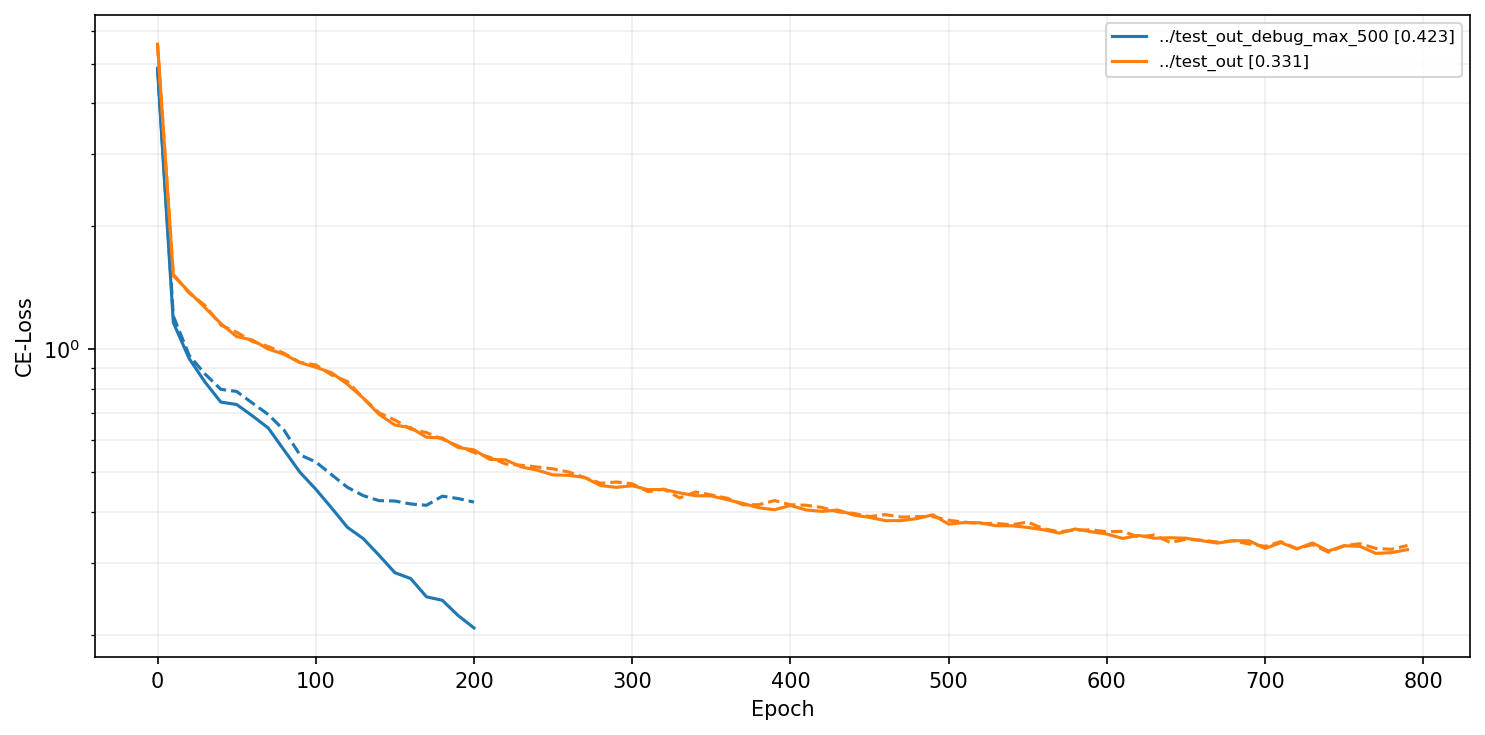

In [1]:
from decifer import (
    plot_loss_curves,
)

plot_loss_curves(
    [
        "../test_out_debug_max_500/ckpt.pt",
        "../test_out/ckpt.pt",
    ],
    ylog = True
)

In [10]:
import multiprocessing as mp
from time import time
from queue import Empty
import h5py
import os
from tqdm.auto import tqdm

decode = Tokenizer().decode

def evaluate_cif(cif):
    eval_dict = {
        'cif': cif,
        'syntax_validity': None,
        'spacegroup': None,
        'cell_params': {
            'a': None,
            'b': None,
            'c': None,
            'alpha': None,
            'beta': None,
            'gamma': None,
            'implied_vol': None,
            'gen_vol': None,
        },
    }
    try:
        eval_dict['syntax_validity'] = evaluate_syntax_validity(cif)
        eval_dict['spacegroup'] = extract_space_group_symbol(cif)
        
        a = extract_numeric_property(cif, "_cell_length_a")
        b = extract_numeric_property(cif, "_cell_length_b")
        c = extract_numeric_property(cif, "_cell_length_c")
        alpha = extract_numeric_property(cif, "_cell_angle_alpha")
        beta = extract_numeric_property(cif, "_cell_angle_beta")
        gamma = extract_numeric_property(cif, "_cell_angle_gamma")
        
        eval_dict['cell_params'] = {
            'a': a,
            'b': b,
            'c': c,
            'alpha': alpha,
            'beta': beta,
            'gamma': gamma,
        }
        eval_dict['cell_params']['implied_vol'] = get_unit_cell_volume(a, b, c, alpha, beta, gamma)
        eval_dict['cell_params']['gen_vol'] = extract_volume(cif)
        
    except Exception as e:
        return eval_dict
    return eval_dict

def worker(input_queue, output_queue):
    while True:
        task = input_queue.get()
        if task is None:
            break
        cif = task['cif']
        idx = task['index']
        try:
            # Move preprocessing steps here
            cif = replace_symmetry_loop_with_P1(cif)
            spacegroup_symbol = extract_space_group_symbol(cif)
            if spacegroup_symbol != "P 1":
                cif = reinstate_symmetry_loop(cif, spacegroup_symbol)
            if is_sensible(cif):
                # Evaluate the CIF
                eval_result = evaluate_cif(cif)
                output_queue.put({'result': eval_result, 'cif': cif, 'index': idx})
            else:
                output_queue.put({'result': None, 'cif': None, 'index': idx})
        except Exception as e:
            output_queue.put({'error': str(e), 'cif': None, 'index': idx})

def save_cif_to_hdf5_batch(hdf5_file, cif_list, idx_list):
    for cif, idx in zip(cif_list, idx_list):
        hdf5_file.create_dataset(f'cif_{idx}', data=cif)

# Set up multiprocessing queues
input_queue = mp.Queue()
output_queue = mp.Queue()

# Start CPU evaluation workers
num_workers = mp.cpu_count() - 1
processes = [mp.Process(target=worker, args=(input_queue, output_queue)) for _ in range(num_workers)]
for p in processes:
    p.start()

def process_dataset(test_dataset, hdf5_file_path='cifs.hdf5', debug_max=None, debug=False):
    evaluations = []
    invalid_cifs = 0
    start = time()

    # Ensure the directory for HDF5 file exists
    hdf5_dir = os.path.dirname(hdf5_file_path)
    if hdf5_dir:
        os.makedirs(hdf5_dir, exist_ok=True)

    # Open HDF5 file for writing CIFs
    with h5py.File(hdf5_file_path, 'w') as hdf5_file:
        pbar = tqdm(total=len(test_dataset), desc='Generating and evaluating...', leave=True)
        n_sent = 0
        for i, sample in enumerate(iter(test_dataset)):
            if debug_max and (i + 1) > debug_max:
                break  # Stop after reaching the debug_max limit
            prompt = extract_prompt(sample[0], model.device, add_composition=True, add_spacegroup=True).unsqueeze(0)
            if prompt is not None:
                out = model.generate(prompt, max_new_tokens=1000, disable_pbar=True)[0].cpu().numpy()
                cif = decode(out)
                # Send the CIF and index to the worker without preprocessing
                task = {'cif': cif, 'index': i}
                input_queue.put(task)
                n_sent += 1
            pbar.update(1)
        pbar.close()

        # Terminate workers
        for _ in range(num_workers):
            input_queue.put(None)  # Poison pill

        # Collect results
        n_received = 0
        cif_buffer = []
        idx_buffer = []
        buffer_size = 10  # Adjust based on your preference
        while n_received < n_sent:
            try:
                message = output_queue.get(timeout=1)
                idx = message['index']
                if 'result' in message:
                    eval_result = message['result']
                    cif = message['cif']
                    if eval_result is not None and cif is not None:
                        evaluations.append(eval_result)
                        # Buffer CIFs for batch writing
                        cif_buffer.append(cif)
                        idx_buffer.append(idx)
                        if len(cif_buffer) >= buffer_size:
                            save_cif_to_hdf5_batch(hdf5_file, cif_buffer, idx_buffer)
                            cif_buffer = []
                            idx_buffer = []
                    else:
                        invalid_cifs += 1
                elif 'error' in message:
                    print(f"Worker error for index {idx}: {message['error']}")
                    invalid_cifs += 1
                n_received += 1
            except Empty:
                continue

        # Save any remaining CIFs in the buffer
        if cif_buffer:
            save_cif_to_hdf5_batch(hdf5_file, cif_buffer, idx_buffer)

        print("n_sent: ", n_sent)
        print("n_received: ", n_received)

    for p in processes:
        p.join()

    print(f"Processed {n_sent} samples in {(time() - start):.3f} seconds.")
    print(f"Successful: {len(evaluations)} / {n_sent}")
    return evaluations, invalid_cifs

# Call the function with debug_max parameter and save CIFs to an HDF5 file
debug_max = 10  # Set to any number or None for full dataset
hdf5_file_path = 'test_cifs.h5'  # Specify the path for the HDF5 file
evaluations, invalid_cifs = process_dataset(test_dataset, hdf5_file_path=hdf5_file_path, debug_max=debug_max, debug=True)


Generating and evaluating...:   0%|          | 0/7016 [00:00<?, ?it/s]

n_sent:  10
n_received:  10
Processed 10 samples in 12.073 seconds.
Successful: 9 / 10
